In [108]:
import pandas as pd
import numpy as np
import fasttext
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from nltk.corpus import stopwords
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
from collections import Counter
from pprint import pprint
import time
import matplotlib.pyplot as plt


In [2]:
reviews_df = pd.read_csv('english_reviews.csv',header=None)
reviews_df.head()

,0
0,Our stay with Marcus in Bristol was fantastic ...
1,"Marcus is a brilliant, warm and friendly host...."
2,My mum Angela and I have stayed at Marcus' ama...
3,Marcus was an exceptional host. I only stayed ...
4,"Marcus was welcoming, easy going and very help..."


In [3]:
reviews = reviews_df[0].to_list()
reviews[0:1]

["Our stay with Marcus in Bristol was fantastic in every way! He was a great host - picking us up at the bus stop, recommending places to try, leaving plenty of pastries and other breakfast items to enjoy in the morning. The flat itself was modern, bright, clean and spacious - and best of all, right on Bristol's lovely harbourside. We will definitely stay again next time we're in Bristol - thanks again Marcus!"]

In [4]:
reviews = [re.sub('\S*@\S*\s?', '', review) for review in reviews]
reviews = [re.sub('\s+',' ',review) for review in reviews]
reviews = [re.sub("\'","",review) for review in reviews]

In [5]:
tokenized_reviews = [gensim.utils.simple_preprocess(str(review), deacc=True)  for review in reviews]
tokenized_reviews[0]

['our',
 'stay',
 'with',
 'marcus',
 'in',
 'bristol',
 'was',
 'fantastic',
 'in',
 'every',
 'way',
 'he',
 'was',
 'great',
 'host',
 'picking',
 'us',
 'up',
 'at',
 'the',
 'bus',
 'stop',
 'recommending',
 'places',
 'to',
 'try',
 'leaving',
 'plenty',
 'of',
 'pastries',
 'and',
 'other',
 'breakfast',
 'items',
 'to',
 'enjoy',
 'in',
 'the',
 'morning',
 'the',
 'flat',
 'itself',
 'was',
 'modern',
 'bright',
 'clean',
 'and',
 'spacious',
 'and',
 'best',
 'of',
 'all',
 'right',
 'on',
 'bristols',
 'lovely',
 'harbourside',
 'we',
 'will',
 'definitely',
 'stay',
 'again',
 'next',
 'time',
 'were',
 'in',
 'bristol',
 'thanks',
 'again',
 'marcus']

In [6]:
len(tokenized_reviews[0])

70

In [7]:
Counter(tokenized_reviews[0])

Counter({'our': 1,
         'stay': 2,
         'with': 1,
         'marcus': 2,
         'in': 4,
         'bristol': 2,
         'was': 3,
         'fantastic': 1,
         'every': 1,
         'way': 1,
         'he': 1,
         'great': 1,
         'host': 1,
         'picking': 1,
         'us': 1,
         'up': 1,
         'at': 1,
         'the': 3,
         'bus': 1,
         'stop': 1,
         'recommending': 1,
         'places': 1,
         'to': 2,
         'try': 1,
         'leaving': 1,
         'plenty': 1,
         'of': 2,
         'pastries': 1,
         'and': 3,
         'other': 1,
         'breakfast': 1,
         'items': 1,
         'enjoy': 1,
         'morning': 1,
         'flat': 1,
         'itself': 1,
         'modern': 1,
         'bright': 1,
         'clean': 1,
         'spacious': 1,
         'best': 1,
         'all': 1,
         'right': 1,
         'on': 1,
         'bristols': 1,
         'lovely': 1,
         'harbourside': 1,
         'we':

In [8]:
stop_words = stopwords.words('english')
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [9]:
for tokenized_review in tokenized_reviews:
    for token in tokenized_review:
        if token in stop_words:
            tokenized_review.remove(token)
           

len(tokenized_reviews[0])
            

47

In [10]:
len(tokenized_reviews)

96544

In [11]:
c=0
for review in tokenized_reviews:
    c+= len(review) 
print("Total number of tokens:",c)

Total number of tokens: 2297359


In [12]:
bigram = gensim.models.Phrases(tokenized_reviews, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[tokenized_reviews], threshold=100)  

In [54]:
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
trigram_mod[bigram_mod[tokenized_reviews[0]]]

['stay',
 'marcus',
 'bristol',
 'fantastic',
 'every',
 'way',
 'was',
 'great',
 'host',
 'picking',
 'us',
 'at',
 'bus_stop',
 'recommending',
 'places',
 'try',
 'leaving',
 'plenty',
 'pastries',
 'other',
 'breakfast',
 'items',
 'enjoy',
 'morning',
 'the',
 'flat',
 'was',
 'modern',
 'bright',
 'clean',
 'spacious',
 'best',
 'all',
 'right',
 'bristols',
 'lovely',
 'harbourside',
 'will',
 'definitely',
 'stay',
 'next',
 'time',
 'in',
 'bristol',
 'thanks',
 'marcus']

In [56]:
reviews_bigram = [bigram_mod[review] for review in tokenized_reviews]
reviews_trigram = [trigram_mod[bigram_mod[review]] for review in tokenized_reviews]

['stay', 'marcus', 'bristol', 'fantastic', 'every', 'way', 'was', 'great', 'host', 'picking', 'us', 'at', 'bus_stop', 'recommending', 'places', 'try', 'leaving', 'plenty', 'pastries', 'other', 'breakfast', 'items', 'enjoy', 'morning', 'the', 'flat', 'was', 'modern', 'bright', 'clean', 'spacious', 'best', 'all', 'right', 'bristols', 'lovely', 'harbourside', 'will', 'definitely', 'stay', 'next', 'time', 'in', 'bristol', 'thanks', 'marcus']


In [67]:
#lemmaztize
allowed_pos = ['w','n','a']
for review in reviews_bigram:
    for index,token in enumerate(review):
         lemma = lemmatizer.lemmatize(token)
         review[index]=lemma
        
lemamatized_reviews = reviews_bigram
lemamatized_reviews[0]

['stay',
 'marcus',
 'bristol',
 'fantastic',
 'every',
 'way',
 'wa',
 'great',
 'host',
 'picking',
 'u',
 'at',
 'bus_stop',
 'recommending',
 'place',
 'try',
 'leaving',
 'plenty',
 'pastry',
 'other',
 'breakfast',
 'item',
 'enjoy',
 'morning',
 'the',
 'flat',
 'wa',
 'modern',
 'bright',
 'clean',
 'spacious',
 'best',
 'all',
 'right',
 'bristol',
 'lovely',
 'harbourside',
 'will',
 'definitely',
 'stay',
 'next',
 'time',
 'in',
 'bristol',
 'thanks',
 'marcus']

In [73]:
id2word = corpora.Dictionary(lemamatized_reviews)
corpus = [id2word.doc2bow(lemamatized_review)for lemamatized_review in lemamatized_reviews]
corpus[0]

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 3),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 1),
 (13, 1),
 (14, 1),
 (15, 1),
 (16, 1),
 (17, 1),
 (18, 1),
 (19, 1),
 (20, 2),
 (21, 1),
 (22, 1),
 (23, 1),
 (24, 1),
 (25, 1),
 (26, 1),
 (27, 1),
 (28, 1),
 (29, 1),
 (30, 1),
 (31, 1),
 (32, 2),
 (33, 1),
 (34, 1),
 (35, 1),
 (36, 1),
 (37, 1),
 (38, 2),
 (39, 1),
 (40, 1)]

In [80]:
[(id2word[index], freq) for index, freq in corpus[0]]

[('all', 1),
 ('at', 1),
 ('best', 1),
 ('breakfast', 1),
 ('bright', 1),
 ('bristol', 3),
 ('bus_stop', 1),
 ('clean', 1),
 ('definitely', 1),
 ('enjoy', 1),
 ('every', 1),
 ('fantastic', 1),
 ('flat', 1),
 ('great', 1),
 ('harbourside', 1),
 ('host', 1),
 ('in', 1),
 ('item', 1),
 ('leaving', 1),
 ('lovely', 1),
 ('marcus', 2),
 ('modern', 1),
 ('morning', 1),
 ('next', 1),
 ('other', 1),
 ('pastry', 1),
 ('picking', 1),
 ('place', 1),
 ('plenty', 1),
 ('recommending', 1),
 ('right', 1),
 ('spacious', 1),
 ('stay', 2),
 ('thanks', 1),
 ('the', 1),
 ('time', 1),
 ('try', 1),
 ('u', 1),
 ('wa', 2),
 ('way', 1),
 ('will', 1)]

In [115]:
start = time.time()
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=23, 
                                           random_state=42,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
time.time()- start

1886.1918740272522

In [116]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(3,
  '0.000*"hyper" + 0.000*"sujet" + 0.000*"costly" + 0.000*"mildew" + '
  '0.000*"rodeado" + 0.000*"agence" + 0.000*"centralite" + 0.000*"choisir" + '
  '0.000*"stripping" + 0.000*"outspoken"'),
 (22,
  '0.194*"bit" + 0.116*"far" + 0.095*"exactly" + 0.089*"expected" + '
  '0.074*"photo" + 0.056*"relaxing" + 0.052*"pleasure" + 0.047*"interesting" + '
  '0.032*"welcomed" + 0.030*"trouble"'),
 (17,
  '0.172*"people" + 0.142*"value" + 0.136*"arrival" + 0.074*"bus_stop" + '
  '0.074*"automated_posting" + 0.053*"bright" + 0.047*"useful" + '
  '0.040*"flexible" + 0.035*"appointed" + 0.033*"ensuite"'),
 (9,
  '0.264*"made" + 0.238*"feel" + 0.179*"welcome" + 0.054*"exploring" + '
  '0.043*"than" + 0.034*"ask" + 0.030*"air_bnb" + 0.022*"appartment" + '
  '0.015*"nicer" + 0.007*"couldnt_asked"'),
 (1,
  '0.144*"just" + 0.132*"quite" + 0.126*"enough" + 0.106*"want" + '
  '0.081*"though" + 0.071*"full" + 0.061*"peaceful" + 0.043*"hospitable" + '
  '0.039*"nicely" + 0.027*"front"'),
 (16,
  '0.2

In [105]:
coherence_values = []
model_list = []
for num_topics in range(10, 25, 3):
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=42,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(lda_model)
        coherencemodel = CoherenceModel(model=lda_model, texts=lemamatized_reviews, dictionary=id2word, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

#print (model_list, coherence_values)

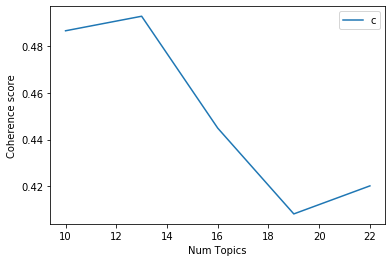

In [111]:
limit=25; start=10; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [112]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 10  has Coherence Value of 0.4867
Num Topics = 13  has Coherence Value of 0.4929
Num Topics = 16  has Coherence Value of 0.4449
Num Topics = 19  has Coherence Value of 0.4081
Num Topics = 22  has Coherence Value of 0.4202


In [ ]:
#svd = TruncatedSVD(n_components=20) #take 20 singular values i.e  latent features 
#latent_features = svd.fit_transform(bag_of_words)#extract hidden features from the bag of words using singular value decomposition


In [ ]:
#latent_features_df = pd.DataFrame(latent_features)
#latent_features_df["body"] = body
#latent_features_df.head()